<a href="https://colab.research.google.com/github/rajiv-ranjan/cds-mini-projects/blob/saif/M2_NB_MiniProject_5_Customer_Segmentation_Kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in Computational Data Science

##  A program by IISc and TalentSprint

### Mini Project Notebook: Customer segmentation using clustering

## Learning Objectives

At the end of the experiment, you will be able to :

* extract summary level insight from a given customer dataset.

* handle the missing data and identify the underlying pattern or structure of the data.

* create an unsupervised model that generates the optimum number of segments for the customer base

* identify customer segments based on the overall buying behaviour


## Dataset

The dataset chosen for this mini project is the Online Retail dataset. It is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.

The dataset contains 541909 records, and each record is made up of 8 fields.

To know more about the dataset : [click here](https://archive.ics.uci.edu/ml/datasets/Online+Retail)

## Information

**Clustering** is the task of grouping together a set of objects so that the objects in the same cluster are more similar to each other than to objects in other clusters. Similarity is a measure that reflects the strength of the relationship between two data objects.

In the clustering calculation, K-Means is a very popular algorithm. In this analysis, this method is used to cluster the similar data items.

In Retail and E-Commerce (B2C), and more broadly in B2B, one of the key elements shaping the business strategy of a firm is understanding of customer behaviour. More specifically, understanding the customers based on different business metrics: how much they spend (revenue), how often they spend (frequency), are they new or existing customers, what are their favorite products, etc... Such understanding in turn helps direct marketing, sales, account management and product teams to support customers on a personalized level and improve the product offering.

Furthermore, segmenting customers into different categories based on similar/cyclical buying pattern over a period of 1 year helps the retail shops manage their inventory better, thereby lowering costs and raising revenues by placing the orders in sync with the buying cycles.

## Problem Statement

Perform customer segmentation for an Online Retail using an Unsupervised Clustering technique

## Grading = 10 Points

### Import Required packages

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

## Data Wrangling

In [2]:
#@title Download the data
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/Online_Retail.zip
!unzip -qq Online_Retail.zip

replace Online_Retail_Train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Load the data

In [2]:
# YOUR CODE HERE
df_train = pd.read_csv('Online_Retail_Train.csv')
print(df_train.shape)
print('\n',df_train.dtypes)
df_train.head()

(514813, 8)

 InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,579427,22636,CHILDS BREAKFAST SET CIRCUS PARADE,2,2011-11-29 13:04:00,8.50,16479.0,United Kingdom
1,554092,21916,SET 12 RETRO WHITE CHALK STICKS,24,2011-05-22 12:41:00,0.42,17176.0,United Kingdom
2,577774,84692,BOX OF 24 COCKTAIL PARASOLS,6,2011-11-21 15:57:00,0.42,16712.0,United Kingdom
3,C571196,23350,ROLL WRAP VINTAGE SPOT,-12,2011-10-14 12:02:00,1.25,NaN,United Kingdom
4,546649,84509a,SET OF 4 ENGLISH ROSE PLACEMATS,1,2011-03-15 14:17:00,7.46,NaN,United Kingdom


## Data Pre-processing (2 points)

Explore the dataset by performing the following operations:

* There is a lot of redundant data. Identify such data and take appropriate action.

  **Hint:** refer to this [link](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html)

* Most Invoices appear as normal transactions with positive quantity and prices, but there are some prefixed with "C" or "A" which denote different transaction types. Invoice starting with C represents cancelled order and A represents the Adjusted. Identify such data and take appropriate action.

  **Hint:** Check the negative values in Quantity column for all cancelled orders

* Handle the null values by dropping or filling with appropriate mean


* Some of the transactions based on the `StockCode` variable are not actually products, but representing the costs or fees regarding to the post or bank or other tansactions. Find such data and handle it accordingly.

  Hint:
    - The transaction with `'POST' 'PADS' 'M' 'DOT' 'C2' 'BANK CHARGES'` as their `StockCodes` are considered as irrelevant transactions.

* Identify the outliers in the UntiPrice and Quantity and handle them accordingly.

  **Hint:** [link](https://thecleverprogrammer.com/2023/07/26/detect-and-remove-outliers-using-python/)

* Create a DayOfWeek column using `InvoiceDate`, Hint: pd.to_datetime()

**Note:** Perform all the above operations using a function to reuse and apply the same for test data.

In [3]:
print("Duplicated Rows: \t")
print(df_train.duplicated().sum())

null_values_per_column = df_train.isnull().sum()
print("\n Null values in each column:")
print(null_values_per_column)

Duplicated Rows: 	
4754

 Null values in each column:
InvoiceNo           0
StockCode           0
Description      1385
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     128263
Country             0
dtype: int64


In [4]:
# YOUR CODE HERE
def remove_duplicates(df):
    df.drop_duplicates(inplace=True)
    return df

In [5]:
def handle_null_values(df):
    df.dropna(subset=['Description', 'CustomerID'], inplace=True)
    return df

In [6]:
def handle_cancelled_adjusted_orders(df):
    adjusted = df[df['InvoiceNo'].str.startswith('A')].index
    df.drop(index=adjusted, inplace=True)

    canceled = df[df['InvoiceNo'].str.startswith('C')].index
    df.drop(index=canceled, inplace=True)

    return df

In [7]:
def remove_irrelevant_transactions(df):
    irrelevant_codes = ['POST', 'PADS', 'M', 'DOT', 'C2', 'BANK CHARGES']
    df = df[~df['StockCode'].isin(irrelevant_codes)]
    return df

In [8]:
def add_day_of_week(df):
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
    df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek
    return df

In [9]:
def handle_outliers(df):
    Q1_quantity = df['Quantity'].quantile(0.25)
    Q3_quantity = df['Quantity'].quantile(0.75)
    IQR_quantity = Q3_quantity - Q1_quantity
    lower_limit_quantity = Q1_quantity - 1.5 * IQR_quantity
    upper_limit_quantity = Q3_quantity + 1.5 * IQR_quantity
    df = df[(df['Quantity'] >= lower_limit_quantity) & (df['Quantity'] <= upper_limit_quantity)]

    Q1_unitprice = df['UnitPrice'].quantile(0.25)
    Q3_unitprice = df['UnitPrice'].quantile(0.75)
    IQR_unitprice = Q3_unitprice - Q1_unitprice
    lower_limit_unitprice = Q1_unitprice - 1.5 * IQR_unitprice
    upper_limit_unitprice = Q3_unitprice + 1.5 * IQR_unitprice
    df = df[(df['UnitPrice'] >= lower_limit_unitprice) & (df['UnitPrice'] <= upper_limit_unitprice)]

    return df

In [10]:
def preprocess_data(df):
    df = remove_duplicates(df)
    df = handle_null_values(df)
    df = remove_irrelevant_transactions(df)
    df = handle_cancelled_adjusted_orders(df)
    df = add_day_of_week(df)
    df = handle_outliers(df)
    return df

In [11]:
df_new = preprocess_data(df_train)
print(df_new.shape)
print('\n',df_new.dtypes)
df_new.head()

<ipython-input-6-868a367a1b83>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(index=adjusted, inplace=True)
<ipython-input-6-868a367a1b83>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(index=canceled, inplace=True)
<ipython-input-8-3223b24faeaa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
<ipython-inp

(316812, 9)

 InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
DayOfWeek               int32
dtype: object


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,DayOfWeek
1,554092,21916,SET 12 RETRO WHITE CHALK STICKS,24,2011-05-22 12:41:00,0.42,17176.0,United Kingdom,6
2,577774,84692,BOX OF 24 COCKTAIL PARASOLS,6,2011-11-21 15:57:00,0.42,16712.0,United Kingdom,0
5,579668,23575,SNACK TRAY PAISLEY PARK,8,2011-11-30 12:32:00,1.95,15152.0,United Kingdom,2
7,547684,23176,ABC TREASURE BOOK BOX,8,2011-03-24 14:46:00,2.25,12408.0,Belgium,3
8,575878,21519,GIN & TONIC DIET GREETING CARD,12,2011-11-11 13:29:00,0.42,13588.0,United Kingdom,4


## Understanding new insights from the data (1 point)

1.  Are there any free items in the data? How many are there?

2.  Find the number of transactions per country and visualize using an appropriate plot

3.  What is the ratio of customers who are repeat purchasers vs single-time purchasers? Visualize using an appropriate plot.

4. Plot heatmap showing unit price per month and day of the week

  **Hint:** Month name as index on Y-axis, Day of the week on X-axis

5. Find the top 10 customers who bought the most no.of items. Also find the top 10 Items bought by most no.of customers.

In [12]:
# YOUR CODE HERE
def find_free_items(df):
    free_items = df[df['UnitPrice'] == 0]
    return free_items.shape[0]

free_item_count = find_free_items(df_new)
print(f"Number of free items: {free_item_count}")

Number of free items: 24


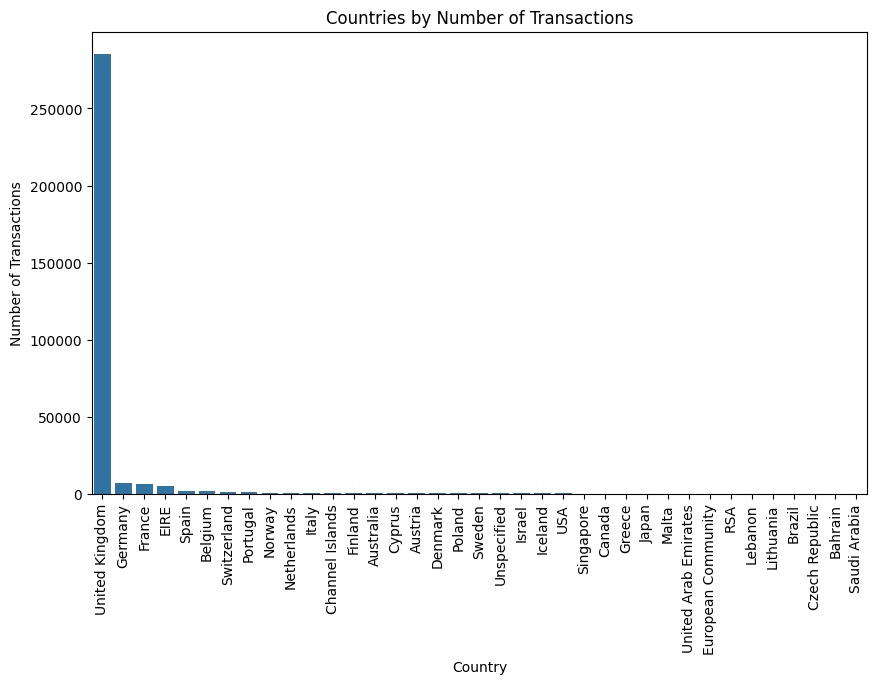

In [13]:
def plot_transactions_per_country(df):
    country_transactions = df['Country'].value_counts().reset_index()
    country_transactions.columns = ['Country', 'Number of Transactions']

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Country', y='Number of Transactions', data=country_transactions.sort_values('Number of Transactions', ascending=False))
    plt.title('Countries by Number of Transactions')
    plt.xlabel('Country')
    plt.ylabel('Number of Transactions')
    plt.xticks(rotation=90)
    plt.show()

plot_transactions_per_country(df_new)

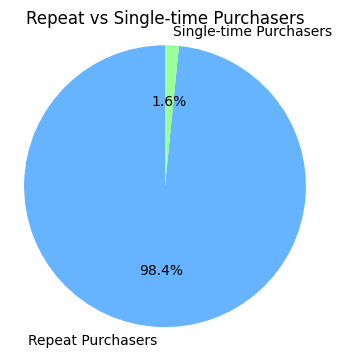

Ratio of repeat to single-time purchasers: 62.42424242424242


In [14]:
def repeat_vs_single_purchasers(df):
    customer_purchase_counts = df['CustomerID'].value_counts()

    single_time_customers = customer_purchase_counts[customer_purchase_counts == 1].count()

    repeat_customers = customer_purchase_counts[customer_purchase_counts > 1].count()

    ratio = repeat_customers / single_time_customers if single_time_customers != 0 else None

    labels = ['Repeat Purchasers', 'Single-time Purchasers']
    sizes = [repeat_customers, single_time_customers]

    plt.figure(figsize=(4, 4))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#99ff99'])
    plt.title('Repeat vs Single-time Purchasers')
    plt.axis('equal')
    plt.show()

    return ratio

ratio = repeat_vs_single_purchasers(df_new)
print(f"Ratio of repeat to single-time purchasers: {ratio}")

<ipython-input-15-54c5be04601c>:7: FutureWarning: The provided callable <function mean at 0x7c328feecd60> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pivot_table = df.pivot_table(values='UnitPrice', index='Month', columns='DayOfWeek', aggfunc=np.mean)


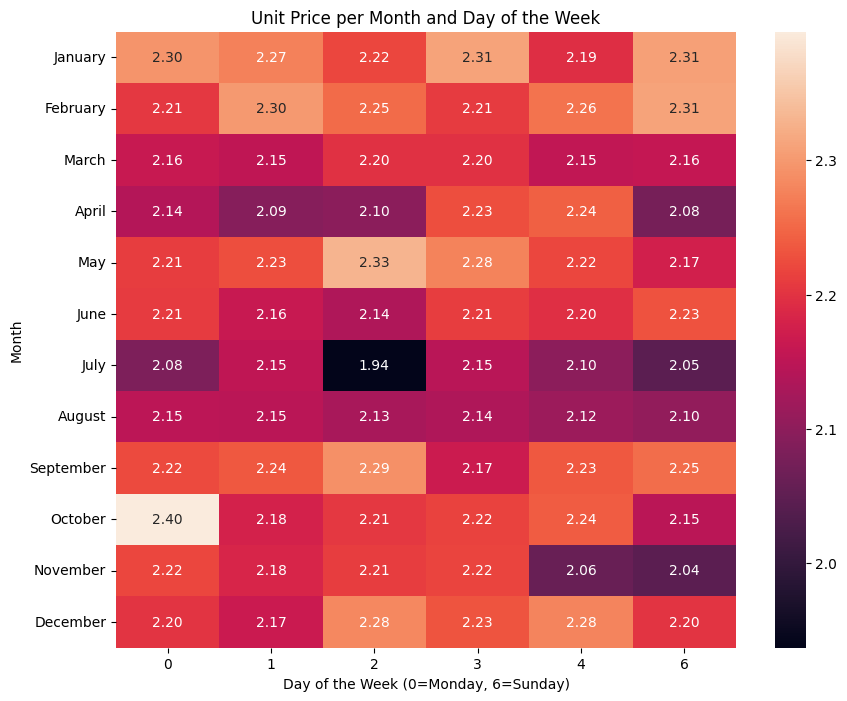

In [15]:
def plot_unit_price_heatmap(df):
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

    df['Month'] = df['InvoiceDate'].dt.month_name()
    df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek

    pivot_table = df.pivot_table(values='UnitPrice', index='Month', columns='DayOfWeek', aggfunc=np.mean)

    month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    pivot_table = pivot_table.reindex(month_order)

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_table, annot=True, fmt='.2f')
    plt.title('Unit Price per Month and Day of the Week')
    plt.ylabel('Month')
    plt.xlabel('Day of the Week (0=Monday, 6=Sunday)')
    plt.show()

plot_unit_price_heatmap(df_new)

In [16]:
def top_10_customers(df):
    customer_quantities = df.groupby('CustomerID')['Quantity'].sum().sort_values(ascending=False)

    top_10_customers = customer_quantities.head(10)

    return top_10_customers

top_10_customers_list = top_10_customers(df_new)
print("Top 10 Customers Who Bought the Most Items:")
print(top_10_customers_list)

Top 10 Customers Who Bought the Most Items:
CustomerID
14911.0    46783
13089.0    19477
17841.0    18508
14298.0    16611
12748.0    14297
14096.0    12837
13081.0    11480
15159.0     7683
15311.0     7604
12921.0     7486
Name: Quantity, dtype: int64


In [17]:
def top_10_items_by_customers(df):
    item_customer_counts = df.groupby('StockCode')['CustomerID'].nunique().sort_values(ascending=False)

    top_10_items = item_customer_counts.head(10)

    return top_10_items

top_10_items_list = top_10_items_by_customers(df_new)
print("Top 10 Items Bought by Most Customers:")
print(top_10_items_list)

Top 10 Items Bought by Most Customers:
StockCode
85123A    742
47566     651
22720     612
84879     601
21212     578
85099B    561
22138     557
22457     557
23298     544
22960     542
Name: CustomerID, dtype: int64


## Feature Engineering and Transformation (2 points)

### Create new features to uncover better insights and drop the unwanted columns

* Create a new column which represents Total amount spent by each customer

    **Hint:** Quantity * UnitPrice

* Customer IDs are seen to be repeated. Maintain unique customer IDs by grouping and summing up all possible observations per customer.

    **Hint:** [pandas.groupby.agg](https://pandas.pydata.org/pandas-docs/version/0.22/generated/pandas.core.groupby.DataFrameGroupBy.agg.html)

**Note:** Perform the above operations in function, to reuse and apply the same for test data

In [18]:
# YOUR CODE HERE
def calculate_total_spent(df):
    df['TotalAmountSpent'] = df['Quantity'] * df['UnitPrice']
    customer_spending = df.groupby('CustomerID').agg({'TotalAmountSpent': 'sum'}).reset_index()

    return customer_spending

customer_spending_data = calculate_total_spent(df_new)
print(customer_spending_data.head())

   CustomerID  TotalAmountSpent
0     12347.0           3096.53
1     12348.0             90.20
2     12349.0            977.51
3     12350.0            294.40
4     12352.0           1130.94


### Scale the data

Apply `StandardScaler` on the features.

In [19]:
# YOUR CODE HERE for scaling
numeric_columns = ['Quantity', 'UnitPrice', 'DayOfWeek']
def apply_standard_scaler(df):
    scaler = StandardScaler()

    df[numeric_columns] = scaler.fit_transform(df[numeric_columns])
    return df

df_scaled = apply_standard_scaler(df_new)
print(df_scaled.head())

  InvoiceNo StockCode                      Description  Quantity  \
1    554092     21916  SET 12 RETRO WHITE CHALK STICKS  2.427025   
2    577774     84692      BOX OF 24 COCKTAIL PARASOLS -0.228650   
5    579668     23575          SNACK TRAY PAISLEY PARK  0.066425   
7    547684     23176           ABC TREASURE BOOK BOX   0.066425   
8    575878     21519  GIN & TONIC DIET GREETING CARD   0.656575   

          InvoiceDate  UnitPrice  CustomerID         Country  DayOfWeek  \
1 2011-05-22 12:41:00  -1.147150     17176.0  United Kingdom   1.730303   
2 2011-11-21 15:57:00  -1.147150     16712.0  United Kingdom  -1.354207   
5 2011-11-30 12:32:00  -0.157815     15152.0  United Kingdom  -0.326037   
7 2011-03-24 14:46:00   0.036172     12408.0         Belgium   0.188048   
8 2011-11-11 13:29:00  -1.147150     13588.0  United Kingdom   0.702133   

      Month  TotalAmountSpent  
1       May             10.08  
2  November              2.52  
5  November             15.60  
7     March 

## Clustering ( 5 points)

### Apply k-means algorithm to identify a specific number of clusters


* Fit the k-means model

* Extract and store the cluster centroids

Below are the parameters for k-means, which are helpful

**n_clusters** is no. of clusters specified

**k-means++** is a random initialization method for centroids to avoid random initialisation trap

**max_iter** is max no of iterations defined when k-means is running

**n_init** is no. of times k-means will run with different initial centroids

[why-is-k-means-slower-than-random-initialization-k-means](https://stats.stackexchange.com/questions/185396/why-is-k-means-slower-than-random-initialization-k-means/185422)

In [22]:
# YOUR CODE HERE to apply KMeans
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10)
kmeans.fit(df_scaled[numeric_columns])
cluster_centroids = kmeans.cluster_centers_
    #return kmeans, cluster_centroids

kmeans_model, centroids = fit_kmeans_model(df_scaled, n_clusters=3)
print(f"Cluster Centroids:\n{centroids}")

Cluster Centroids:
[[-0.49680457 -0.09465299  1.14438191]
 [-0.57151842  0.57227708 -0.63328971]
 [ 1.16040707 -0.61960377 -0.26658356]]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


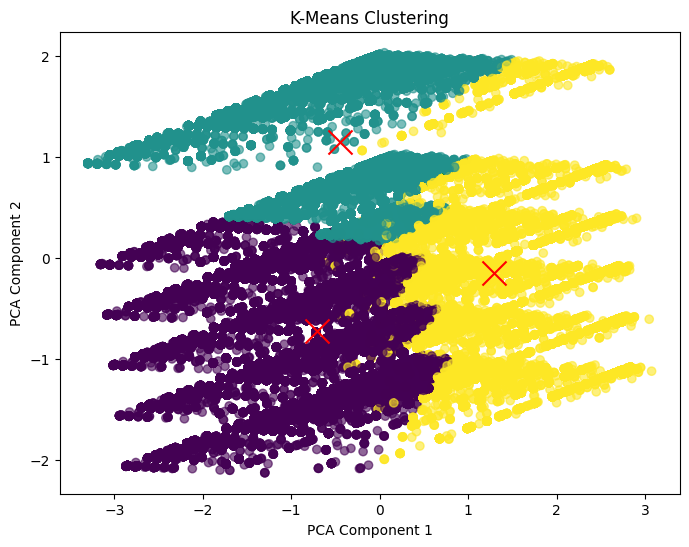

In [23]:
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled[numeric_columns])
labels = kmeans.predict(df_scaled[numeric_columns])

centroids_pca = pca.transform(centroids)

plt.figure(figsize=(8, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], s=300, c='red', marker='x')  # Plot centroids
plt.title('K-Means Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

#### Find the optimal number of clusters (K) by using the [Elbow method](https://pythonprogramminglanguage.com/kmeans-elbow-method/).

Use the optimal no. of clusters and store the cluster centroids

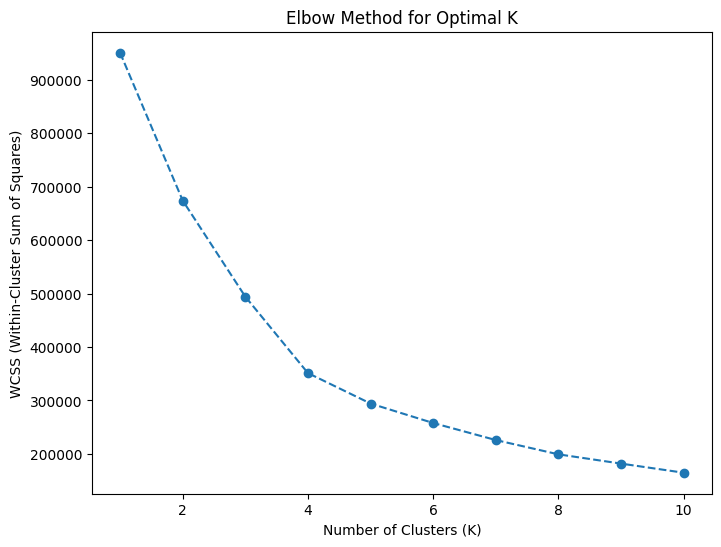

In [24]:
# YOUR CODE HERE
wcss = []
for k in range(1, 10 + 1):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10)
    kmeans.fit(df_scaled[numeric_columns])
    wcss.append(kmeans.inertia_)  # inertia_ is the WCSS value for the given k

plt.figure(figsize=(8, 6))
plt.plot(range(1, 10 + 1), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.show()

### Apply DBSCAN algorithm for clustering

- Compare the results of clusters from k-means and DBSCAN


In [ ]:
# YOUR CODE HERE
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(df_scaled[numeric_columns])

pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled[numeric_columns])

sampled_indices = np.random.choice(df_pca.shape[0], size=5000, replace=False)  # Take 5000 random samples
df_pca_sampled = df_pca[sampled_indices]
dbscan_labels_sampled = dbscan_labels[sampled_indices]

# Plot DBSCAN clusters
plt.figure(figsize=(8, 6))
plt.scatter(df_pca_sampled[:, 0], df_pca_sampled[:, 1], c=dbscan_labels_sampled, cmap='viridis', alpha=0.6)
plt.title('DBSCAN Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

unique_labels = np.unique(dbscan_labels)
print(f"Unique cluster labels (including noise points as -1): {unique_labels}")

### Analyze the clusters


- consider two features and visualize the clusters with different colors using the predicted cluster centers.

  **Hint:** 2D plot

- consider three features and visualize the clusters with different colors using the predicted cluster centers.

  **Hint:** [3D plot](https://matplotlib.org/stable/gallery/mplot3d/scatter3d.html
)

In [ ]:
# YOUR CODE HERE

### Train a supervised algorithm on clustered data

This will allow us to predict cluster numbers (label) for each test data instance

* Create labelled data with k-means cluster labels
  
  **Hint**: [`kmeans.labels_`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
)
* Split the data into train and validation sets
* Train a supervised algorithm on the train data
* Find the accuracy of the model using validation data

In [ ]:
# YOUR CODE HERE

### Evaluation of Test Data
* Use the model to predict the labels for the Test data below
* Format the test data in the same format as the train data.
* Predict it with trained supervised ML model

In [ ]:
# Test set provided as below
test = pd.read_csv("Online_Retail_Test.csv")
test.head(3)

In [ ]:
# YOUR CODE HERE

### Report Analysis

- Discuss the pros and cons of removing the missing values vs replacing with the mean values
- Based on the visualization of clusters, comment on the difference in buying patterns of each cluster
- What other methods could be used to determine the optimal no. of clusters?